In [2]:
from lxml import etree
import re
import numpy as np
import pandas as pd
import glob
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler,LabelEncoder,label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics



In [3]:
df = pd.DataFrame()
path = './data/French Ligue One 20162017 season - Match Day 1- 19/*.xml' 
files = glob.glob(path)
liste =[]
for filename in files:
    root = etree.parse(filename)
    for node_event in root.getiterator('Event'):
        liste.append({'Event' : node_event.attrib.get('id'),
                      'type_id' : node_event.attrib.get('type_id'),
                      'player_id' : node_event.attrib.get('player_id'),
                      'outcome' : node_event.attrib.get('outcome'),
                      'period_id': node_event.attrib.get('period_id'),
                      'min':node_event.attrib.get('min'),
                      'x': node_event.attrib.get('x'),
                      'y': node_event.attrib.get('y')})

In [4]:
df = pd.DataFrame(liste, columns=['Event','type_id', 'outcome','period_id','min', 'x', 'y', 'player_id'])
df = df.astype({'Event': 'int', 'type_id': 'int', 'outcome': 'int', 'x':'float', 'y':'float','period_id':'int','min':'int'})
df = df.set_index('Event')
df

type_id  outcome  period_id  min     x     y player_id
Event                                                             
1317941429       34        1         16    0   0.0   0.0      None
1068730640       34        1         16    0   0.0   0.0      None
1302720130       32        1          1    0   0.0   0.0      None
1455263236       32        1          1    0   0.0   0.0      None
247567393         1        1          1    0  49.7  48.7    229605
...             ...      ...        ...  ...   ...   ...       ...
105366416        30        1          2   92   0.0   0.0      None
953695260        30        1         14    0   0.0   0.0      None
1125459369       37        1         14    0   0.0   0.0      None
1939935194       30        1         14    0   0.0   0.0      None
1127381362       37        1         14    0   0.0   0.0      None

[335429 rows x 7 columns]

In [5]:
df.loc[df['player_id'].isna()]

type_id  outcome  period_id  min    x    y player_id
Event                                                           
1317941429       34        1         16    0  0.0  0.0      None
1068730640       34        1         16    0  0.0  0.0      None
1302720130       32        1          1    0  0.0  0.0      None
1455263236       32        1          1    0  0.0  0.0      None
301370242        30        1          1   45  0.0  0.0      None
...             ...      ...        ...  ...  ...  ...       ...
105366416        30        1          2   92  0.0  0.0      None
953695260        30        1         14    0  0.0  0.0      None
1125459369       37        1         14    0  0.0  0.0      None
1939935194       30        1         14    0  0.0  0.0      None
1127381362       37        1         14    0  0.0  0.0      None

[5434 rows x 7 columns]

In [6]:
df['type_id'].unique()

array([34, 32,  1, 49, 61,  5, 15, 10, 52, 12,  4,  8, 50,  7, 43, 55,  2,
        6, 44,  3, 16, 74, 45, 14, 41, 13, 30, 56, 68, 18, 19, 11, 17, 70,
       37, 42, 27, 28, 40, 65, 59, 51, 53, 54, 58, 60, 25, 57, 24, 20])

In [7]:
df['type_id'].nunique()

50

In [8]:
df['outcome'].unique()

array([1, 0])

In [9]:
df.isna().any()

type_id      False
outcome      False
period_id    False
min          False
x            False
y            False
player_id     True
dtype: bool

In [10]:
list_event_removed = [18,19,34, 32, 30, 68, 70, 37, 27, 28, 65, 25, 57, 24, 20, 40, 43]

In [11]:
df_event_removed = df.loc[~df['type_id'].isin(list_event_removed)]
df_event_removed.loc[df_event_removed['player_id'].isna(), 'type_id'].value_counts()

4     262
5      36
17      3
1       1
Name: type_id, dtype: int64

In [12]:
df_event_removed = df_event_removed.dropna()
df_event_removed
#histogramme distribution nb_event/joueur

type_id  outcome  period_id  min     x     y player_id
Event                                                             
247567393         1        1          1    0  49.7  48.7    229605
563864890         1        1          1    0  50.3  51.5     68690
582737018         1        1          1    0  28.7  72.0    120773
1213336890        1        1          1    0  39.2  86.2    145221
1765553461        1        1          1    0  58.8  79.1     52154
...             ...      ...        ...  ...   ...   ...       ...
1785707030       61        1          2   91  89.8  55.2     51090
1678350972       49        1          2   91  15.8  60.2    203325
190426587         1        1          2   91  15.8  60.2    203325
2139031855       61        0          2   92  27.0  93.6    210415
865683020        49        1          2   92  75.8   8.9     95715

[321388 rows x 7 columns]

In [13]:
event_nb = sorted(df_event_removed['type_id'].unique())

In [14]:
event = ['Pass', 'Offside Pass', 'Take On', 'Foul', 'Out', 
         'Corner Awarded', 'Tackle', 'Interception', 'Save',
        'Claim', 'Clearance', 'Miss', 'Post', 'Attempt Saved', 
        'Goal', 'Card', 'Punch',
         'Good skill', 'Aerial', 'Challenge', 'Ball Recovery',
        'Dispossessed', 'Error', 'Keeper pick-up', 
         'Cross not claimed', 'Smother', 'Offside provoked', 
         'Shield ball opp', 'Penalty faced', 'Chance missed',
        'Keeper Sweeper', 'Ball touch', 'Blocked Pass']

In [15]:
event_dict = {}
for k, v in zip(event_nb, event):
    event_dict[k] = v

In [16]:
df_event_removed.loc[:, 'type_id'] = df_event_removed.loc[:, 'type_id'].apply(lambda x : event_dict[x])

In [17]:
def split_match (row):
    #print(row['min'])

    if row['min'] <= 15:
        match_div=1
    elif row['min']<=30:
        match_div=2
    elif row['min']>30 and row['period_id']==1:
        match_div=3
    elif row['min']<=60:
        match_div=4
    elif row['min']<=75:
        match_div=5
    else :
        match_div=6
    return match_div

In [18]:
df_event_removed['match_div']=df_event_removed.apply(lambda row: split_match(row),axis=1)


In [19]:
df_event_removed

type_id  outcome  period_id  min     x     y player_id  \
Event                                                                      
247567393            Pass        1          1    0  49.7  48.7    229605   
563864890            Pass        1          1    0  50.3  51.5     68690   
582737018            Pass        1          1    0  28.7  72.0    120773   
1213336890           Pass        1          1    0  39.2  86.2    145221   
1765553461           Pass        1          1    0  58.8  79.1     52154   
...                   ...      ...        ...  ...   ...   ...       ...   
1785707030     Ball touch        1          2   91  89.8  55.2     51090   
1678350972  Ball Recovery        1          2   91  15.8  60.2    203325   
190426587            Pass        1          2   91  15.8  60.2    203325   
2139031855     Ball touch        0          2   92  27.0  93.6    210415   
865683020   Ball Recovery        1          2   92  75.8   8.9     95715   

            match_div  
Event                  
247567393           1  
563864890           1  
582737018           1  
1213336890          1  
1765553461          1  
...               ...  
1785707030          6  
1678350972          6  
190426587           6  
2139031855          6  
865683020           6  

[321388 rows x 8 columns]

In [20]:
df_nb_event_per_player = pd.DataFrame(df_event_removed.loc[df_event_removed.index, 'player_id'].value_counts())
df_nb_event_per_player = df_nb_event_per_player.rename(columns={'player_id':'nb_Event'})
# df_nb_event_per_player_500 = df_nb_event_per_player.loc[df_nb_event_per_player['nb_Event'] < 500]

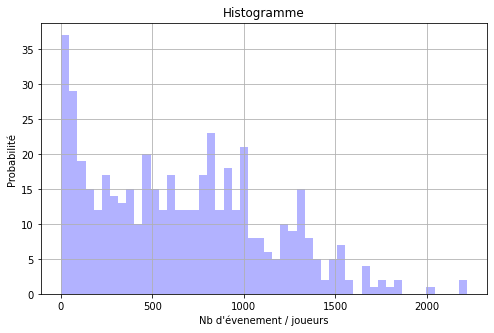

In [21]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)

n, bins, patches = plt.hist(df_nb_event_per_player, 50, density=False, color='b', alpha=0.3)

plt.xlabel("Nb d'évenement / joueurs")
plt.ylabel('Probabilité')
plt.title('Histogramme')
plt.grid(True)

plt.show()

In [22]:
df_nb_event_per_player_250 = df_nb_event_per_player.loc[df_nb_event_per_player['nb_Event'] < 250]

In [23]:
df_event_player_removed = df_event_removed.loc[~df_event_removed['player_id'].isin(df_nb_event_per_player_250.index)]
df_event_player_removed

type_id  outcome  period_id  min     x     y player_id  \
Event                                                                      
247567393            Pass        1          1    0  49.7  48.7    229605   
563864890            Pass        1          1    0  50.3  51.5     68690   
1213336890           Pass        1          1    0  39.2  86.2    145221   
1765553461           Pass        1          1    0  58.8  79.1     52154   
1966074232           Pass        1          1    0  55.9  95.0     61704   
...                   ...      ...        ...  ...   ...   ...       ...   
1785707030     Ball touch        1          2   91  89.8  55.2     51090   
1678350972  Ball Recovery        1          2   91  15.8  60.2    203325   
190426587            Pass        1          2   91  15.8  60.2    203325   
2139031855     Ball touch        0          2   92  27.0  93.6    210415   
865683020   Ball Recovery        1          2   92  75.8   8.9     95715   

            match_div  
Event                  
247567393           1  
563864890           1  
1213336890          1  
1765553461          1  
1966074232          1  
...               ...  
1785707030          6  
1678350972          6  
190426587           6  
2139031855          6  
865683020           6  

[309325 rows x 8 columns]

In [24]:
enc = OneHotEncoder()
X_event_type_id = np.array(df_event_player_removed['type_id']).reshape(-1,1)
enc.fit(X_event_type_id)
enc.categories_

[array(['Aerial', 'Attempt Saved', 'Ball Recovery', 'Ball touch',
        'Blocked Pass', 'Card', 'Challenge', 'Chance missed', 'Claim',
        'Clearance', 'Corner Awarded', 'Cross not claimed', 'Dispossessed',
        'Error', 'Foul', 'Goal', 'Good skill', 'Interception',
        'Keeper Sweeper', 'Keeper pick-up', 'Miss', 'Offside Pass',
        'Offside provoked', 'Out', 'Pass', 'Penalty faced', 'Post',
        'Punch', 'Save', 'Shield ball opp', 'Smother', 'Tackle', 'Take On'],
       dtype=object)]

In [25]:
ohe_event_id = enc.fit_transform(X_event_type_id).toarray()

In [26]:
column_event_id = enc.get_feature_names_out(['enc'])

In [27]:
column_event_id

array(['enc_Aerial', 'enc_Attempt Saved', 'enc_Ball Recovery',
       'enc_Ball touch', 'enc_Blocked Pass', 'enc_Card', 'enc_Challenge',
       'enc_Chance missed', 'enc_Claim', 'enc_Clearance',
       'enc_Corner Awarded', 'enc_Cross not claimed', 'enc_Dispossessed',
       'enc_Error', 'enc_Foul', 'enc_Goal', 'enc_Good skill',
       'enc_Interception', 'enc_Keeper Sweeper', 'enc_Keeper pick-up',
       'enc_Miss', 'enc_Offside Pass', 'enc_Offside provoked', 'enc_Out',
       'enc_Pass', 'enc_Penalty faced', 'enc_Post', 'enc_Punch',
       'enc_Save', 'enc_Shield ball opp', 'enc_Smother', 'enc_Tackle',
       'enc_Take On'], dtype=object)

In [28]:
df_ohe_event_id = pd.DataFrame(ohe_event_id, columns=column_event_id)
df_event_player_removed = df_event_player_removed.reset_index()
df_ohe = pd.concat([df_event_player_removed, df_ohe_event_id], axis=1)
df_ohe.set_index(['Event'])

type_id  outcome  period_id  min     x     y player_id  \
Event                                                                      
247567393            Pass        1          1    0  49.7  48.7    229605   
563864890            Pass        1          1    0  50.3  51.5     68690   
1213336890           Pass        1          1    0  39.2  86.2    145221   
1765553461           Pass        1          1    0  58.8  79.1     52154   
1966074232           Pass        1          1    0  55.9  95.0     61704   
...                   ...      ...        ...  ...   ...   ...       ...   
1785707030     Ball touch        1          2   91  89.8  55.2     51090   
1678350972  Ball Recovery        1          2   91  15.8  60.2    203325   
190426587            Pass        1          2   91  15.8  60.2    203325   
2139031855     Ball touch        0          2   92  27.0  93.6    210415   
865683020   Ball Recovery        1          2   92  75.8   8.9     95715   

            match_div  enc_Aerial  enc_Attempt Saved  ...  enc_Out  enc_Pass  \
Event                                                 ...                      
247567393           1         0.0                0.0  ...      0.0       1.0   
563864890           1         0.0                0.0  ...      0.0       1.0   
1213336890          1         0.0                0.0  ...      0.0       1.0   
1765553461          1         0.0                0.0  ...      0.0       1.0   
1966074232          1         0.0                0.0  ...      0.0       1.0   
...               ...         ...                ...  ...      ...       ...   
1785707030          6         0.0                0.0  ...      0.0       0.0   
1678350972          6         0.0                0.0  ...      0.0       0.0   
190426587           6         0.0                0.0  ...      0.0       1.0   
2139031855          6         0.0                0.0  ...      0.0       0.0   
865683020           6         0.0                0.0  ...      0.0       0.0   

            enc_Penalty faced  enc_Post  enc_Punch  enc_Save  \
Event                                                          
247567393                 0.0       0.0        0.0       0.0   
563864890                 0.0       0.0        0.0       0.0   
1213336890                0.0       0.0        0.0       0.0   
1765553461                0.0       0.0        0.0       0.0   
1966074232                0.0       0.0        0.0       0.0   
...                       ...       ...        ...       ...   
1785707030                0.0       0.0        0.0       0.0   
1678350972                0.0       0.0        0.0       0.0   
190426587                 0.0       0.0        0.0       0.0   
2139031855                0.0       0.0        0.0       0.0   
865683020                 0.0       0.0        0.0       0.0   

            enc_Shield ball opp  enc_Smother  enc_Tackle  enc_Take On  
Event                                                                  
247567393                   0.0          0.0         0.0          0.0  
563864890                   0.0          0.0         0.0          0.0  
1213336890                  0.0          0.0         0.0          0.0  
1765553461                  0.0          0.0         0.0          0.0  
1966074232                  0.0          0.0         0.0          0.0  
...                         ...          ...         ...          ...  
1785707030                  0.0          0.0         0.0          0.0  
1678350972                  0.0          0.0         0.0          0.0  
190426587                   0.0          0.0         0.0          0.0  
2139031855                  0.0          0.0         0.0          0.0  
865683020                   0.0          0.0         0.0          0.0  

[309325 rows x 41 columns]

In [29]:
df_ohe.isna().any()

Event                    False
type_id                  False
outcome                  False
period_id                False
min                      False
x                        False
y                        False
player_id                False
match_div                False
enc_Aerial               False
enc_Attempt Saved        False
enc_Ball Recovery        False
enc_Ball touch           False
enc_Blocked Pass         False
enc_Card                 False
enc_Challenge            False
enc_Chance missed        False
enc_Claim                False
enc_Clearance            False
enc_Corner Awarded       False
enc_Cross not claimed    False
enc_Dispossessed         False
enc_Error                False
enc_Foul                 False
enc_Goal                 False
enc_Good skill           False
enc_Interception         False
enc_Keeper Sweeper       False
enc_Keeper pick-up       False
enc_Miss                 False
enc_Offside Pass         False
enc_Offside provoked     False
enc_Out 

In [30]:
df_player_event = df_ohe.groupby('player_id')[column_event_id].apply(sum)
df_player_event

enc_Aerial  enc_Attempt Saved  enc_Ball Recovery  enc_Ball touch  \
player_id                                                                     
100954           51.0                1.0               83.0            28.0   
100955           18.0                4.0               66.0            29.0   
101494            9.0                4.0               96.0            18.0   
101779           48.0                3.0               68.0            44.0   
102739           40.0                1.0               92.0            13.0   
...               ...                ...                ...             ...   
98788            19.0                8.0               42.0            39.0   
98914            62.0                6.0               14.0            13.0   
9980             26.0                7.0              119.0            36.0   
9997              3.0                0.0               18.0             4.0   
9999              3.0                0.0               12.0             2.0   

           enc_Blocked Pass  enc_Card  enc_Challenge  enc_Chance missed  \
player_id                                                                 
100954                  9.0       1.0            8.0                0.0   
100955                 11.0       6.0           16.0                0.0   
101494                 13.0       3.0           14.0                0.0   
101779                 24.0       1.0           20.0                0.0   
102739                  7.0       3.0           11.0                0.0   
...                     ...       ...            ...                ...   
98788                   7.0       0.0           15.0                0.0   
98914                   3.0       0.0            4.0                0.0   
9980                   17.0       4.0           25.0                0.0   
9997                    0.0       1.0            0.0                5.0   
9999                    0.0       0.0            0.0               15.0   

           enc_Claim  enc_Clearance  ...  enc_Out  enc_Pass  \
player_id                            ...                      
100954           0.0           64.0  ...    167.0     779.0   
100955           0.0           30.0  ...    104.0     477.0   
101494           0.0           24.0  ...     42.0     637.0   
101779           0.0           19.0  ...     91.0     421.0   
102739           0.0          130.0  ...    108.0     806.0   
...              ...            ...  ...      ...       ...   
98788            0.0            3.0  ...     52.0     296.0   
98914            0.0           13.0  ...     27.0     153.0   
9980             0.0           16.0  ...     83.0     820.0   
9997            12.0            5.0  ...     36.0     495.0   
9999             6.0            5.0  ...     35.0     276.0   

           enc_Penalty faced  enc_Post  enc_Punch  enc_Save  \
player_id                                                     
100954                   0.0       0.0        0.0       5.0   
100955                   0.0       0.0        0.0       3.0   
101494                   0.0       0.0        0.0       3.0   
101779                   0.0       0.0        0.0       3.0   
102739                   0.0       0.0        0.0      18.0   
...                      ...       ...        ...       ...   
98788                    0.0       0.0        0.0       1.0   
98914                    0.0       0.0        0.0       1.0   
9980                     0.0       1.0        0.0       3.0   
9997                     4.0       0.0        7.0      33.0   
9999                     1.0       0.0        3.0      20.0   

           enc_Shield ball opp  enc_Smother  enc_Tackle  enc_Take On  
player_id                                                             
100954                     0.0          0.0        18.0         41.0  
100955                     0.0          0.0        32.0          6.0  
101494                     1.0          0.0        29.0          7.0  
101779      

In [31]:
X_player_event_CR = preprocessing.scale(df_player_event[column_event_id])

In [32]:
pcaCR = PCA()
pcaCR.fit(X_player_event_CR)

ratios = pcaCR.explained_variance_ratio_
print(ratios)

[0.28767043 0.15405065 0.14029068 0.05991906 0.04273844 0.02970065
 0.02941244 0.02740444 0.02434665 0.02255046 0.02159026 0.01874018
 0.01685222 0.01545011 0.01187377 0.01095772 0.01020328 0.00979858
 0.00893859 0.0077325  0.00685475 0.00630516 0.00563303 0.0047612
 0.00445877 0.00418546 0.00371117 0.00352536 0.00295522 0.00279505
 0.00230554 0.0016019  0.00068629]


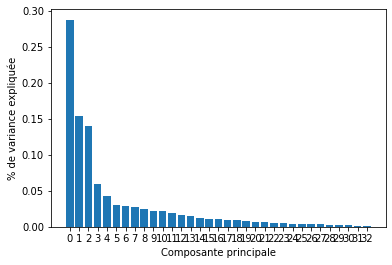

In [33]:
plt.bar(range(len(ratios)), ratios)
plt.xticks(range(len(ratios)))
plt.xlabel("Composante principale")
plt.ylabel("% de variance expliquée")
plt.show()

In [34]:
player_eventNt = pcaCR.transform(X_player_event_CR)
df_player_eventNt = pd.DataFrame(player_eventNt)
df_player_eventNt.columns

RangeIndex(start=0, stop=33, step=1)

In [35]:
root = etree.parse('data/Noms des joueurs et IDs - F40 - L1 20162017.xml')
liste = [
    {'team': node_team.find("Name").text,
     'uID': node_player.attrib["uID"],
     'name': node_player.find("Name").text,
     'position': node_player.find("Position").text,
     node_info.attrib['Type']:node_info.text

       }
        for node_team in root.getiterator("Team")
            for node_player in node_team.getiterator("Player")
                for node_info in node_player.getiterator("Stat")
]
df_player=pd.DataFrame(liste)
df_player=df_player.groupby('name').first().sort_values('team').reset_index() #combine rows with same name value
df_player['uID']=df_player['uID'].apply(lambda x: re.search('\d+',x).group(0))
df_player.set_index("uID",inplace=True)
df_player_event=df_player_event.join(df_player[['name','team','position']])

df_player_event

enc_Aerial  enc_Attempt Saved  enc_Ball Recovery  enc_Ball touch  \
player_id                                                                     
100954           51.0                1.0               83.0            28.0   
100955           18.0                4.0               66.0            29.0   
101494            9.0                4.0               96.0            18.0   
101779           48.0                3.0               68.0            44.0   
102739           40.0                1.0               92.0            13.0   
...               ...                ...                ...             ...   
98788            19.0                8.0               42.0            39.0   
98914            62.0                6.0               14.0            13.0   
9980             26.0                7.0              119.0            36.0   
9997              3.0                0.0               18.0             4.0   
9999              3.0                0.0               12.0             2.0   

           enc_Blocked Pass  enc_Card  enc_Challenge  enc_Chance missed  \
player_id                                                                 
100954                  9.0       1.0            8.0                0.0   
100955                 11.0       6.0           16.0                0.0   
101494                 13.0       3.0           14.0                0.0   
101779                 24.0       1.0           20.0                0.0   
102739                  7.0       3.0           11.0                0.0   
...                     ...       ...            ...                ...   
98788                   7.0       0.0           15.0                0.0   
98914                   3.0       0.0            4.0                0.0   
9980                   17.0       4.0           25.0                0.0   
9997                    0.0       1.0            0.0                5.0   
9999                    0.0       0.0            0.0               15.0   

           enc_Claim  enc_Clearance  ...  enc_Post  enc_Punch  enc_Save  \
player_id                            ...                                  
100954           0.0           64.0  ...       0.0        0.0       5.0   
100955           0.0           30.0  ...       0.0        0.0       3.0   
101494           0.0           24.0  ...       0.0        0.0       3.0   
101779           0.0           19.0  ...       0.0        0.0       3.0   
102739           0.0          130.0  ...       0.0        0.0      18.0   
...              ...            ...  ...       ...        ...       ...   
98788            0.0            3.0  ...       0.0        0.0       1.0   
98914            0.0           13.0  ...       0.0        0.0       1.0   
9980             0.0           16.0  ...       1.0        0.0       3.0   
9997            12.0            5.0  ...       0.0        7.0      33.0   
9999             6.0            5.0  ...       0.0        3.0      20.0   

           enc_Shield ball opp  enc_Smother  enc_Tackle  enc_Take On  \
player_id                                                              
100954                     0.0          0.0        18.0         41.0   
100955                     0.0          0.0        32.0          6.0   
101494                     1.0          0.0        29.0          7.0   
101779                     1.0          0.0        30.0         46.0   
102739                     0.0          0.0        33.0          0.0   
...                        ...          ...         ...          ...   
98788                      0.0          0.0        17.0         49.0   
98914                      0.0          0.0         7.0          2.0   
9980                       0.0          0.0        45.0          2.0   
9997                       0.0          3.0         0.0          0.0   
9999                       0.0          5.0         0.0          0.0   

                         name         team    position  
player_id                            

In [36]:
df_player_corr = df_player_event.iloc[:,:-3]

In [37]:
scaler = StandardScaler().fit(df_player_corr)

df_corrCR = pd.DataFrame(scaler.transform(df_player_corr), columns=df_player_corr.columns)

In [38]:
df_corrCR

enc_Aerial  enc_Attempt Saved  enc_Ball Recovery  enc_Ball touch  \
0      0.671474          -0.722554           0.786049        0.247468   
1     -0.505291          -0.217964           0.263560        0.306814   
2     -0.826226          -0.217964           1.185600       -0.345999   
3      0.564495          -0.386161           0.325029        1.197014   
4      0.279219          -0.722554           1.062661       -0.642733   
..          ...                ...                ...             ...   
360   -0.469631           0.454822          -0.474072        0.900281   
361    1.063729           0.118429          -1.334642       -0.642733   
362   -0.220014           0.286625           1.892497        0.722241   
363   -1.040184          -0.890751          -1.211703       -1.176853   
364   -1.040184          -0.890751          -1.396111       -1.295546   

     enc_Blocked Pass  enc_Card  enc_Challenge  enc_Chance missed  enc_Claim  \
0            0.105607 -0.530625      -0.240798          -0.221264  -0.236908   
1            0.436478  2.467486       0.778233          -0.221264  -0.236908   
2            0.767350  0.668620       0.523475          -0.221264  -0.236908   
3            2.587143 -0.530625       1.287748          -0.221264  -0.236908   
4           -0.225265  0.668620       0.141338          -0.221264  -0.236908   
..                ...       ...            ...                ...        ...   
360         -0.225265 -1.130247       0.650854          -0.221264  -0.236908   
361         -0.887008 -1.130247      -0.750314          -0.221264  -0.236908   
362          1.429093  1.268242       1.924643          -0.221264  -0.236908   
363         -1.383315 -0.530625      -1.259830           1.605917   2.043656   
364         -1.383315 -1.130247      -1.259830           5.260279   0.903374   

     enc_Clearance  ...   enc_Out  enc_Pass  enc_Penalty faced  enc_Post  \
0         1.379852  ...  3.024727  1.069623          -0.234285 -0.447792   
1         0.160457  ...  1.182833 -0.064380          -0.234285 -0.447792   
2        -0.054730  ... -0.629824  0.536417          -0.234285 -0.447792   
3        -0.234053  ...  0.802760 -0.274659          -0.234285 -0.447792   
4         3.746913  ...  1.299779  1.171008          -0.234285 -0.447792   
..             ...  ...       ...       ...                ...       ...   
360      -0.807886  ... -0.337460 -0.744031          -0.234285 -0.447792   
361      -0.449240  ... -1.068371 -1.280993          -0.234285 -0.447792   
362      -0.341647  ...  0.568868  1.223578          -0.234285  1.521415   
363      -0.736157  ... -0.805243  0.003210           4.652239 -0.447792   
364      -0.736157  ... -0.834479 -0.819130           0.987346 -0.447792   

     enc_Punch  enc_Save  enc_Shield ball opp  enc_Smother  enc_Tackle  \
0    -0.230612 -0.031474            -0.512812    -0.200540   -0.064088   
1    -0.230612 -0.215281            -0.512812    -0.200540    0.946690   
2    -0.230612 -0.215281             0.718611    -0.200540    0.730095   
3    -0.230612 -0.215281             0.718611    -0.200540    0.802293   
4    -0.230612  1.163275            -0.512812    -0.200540    1.018888   
..         ...       ...                  ...          ...         ...   
360  -0.230612 -0.399089            -0.512812    -0.200540   -0.136287   
361  -0.230612 -0.399089            -0.512812    -0.200540   -0.858272   
362  -0.230612 -0.215281            -0.512812    -0.200540    1.885270   
363   3.235345  2.541831            -0.512812     2.239368   -1.363661   
364   1.254798  1.347082            -0.512812     3.865974   -1.363661   

     enc_Take On  
0       1.193193  
1      -0.642654  
2      -0.590202  
3       1.455457  
4      -0.957371  
..           ...  
360     1.612815  
361    -0.852466  
362    -0.852466  
363    -0.957371  
364    -0.957371  

[365 rows x 33 columns]

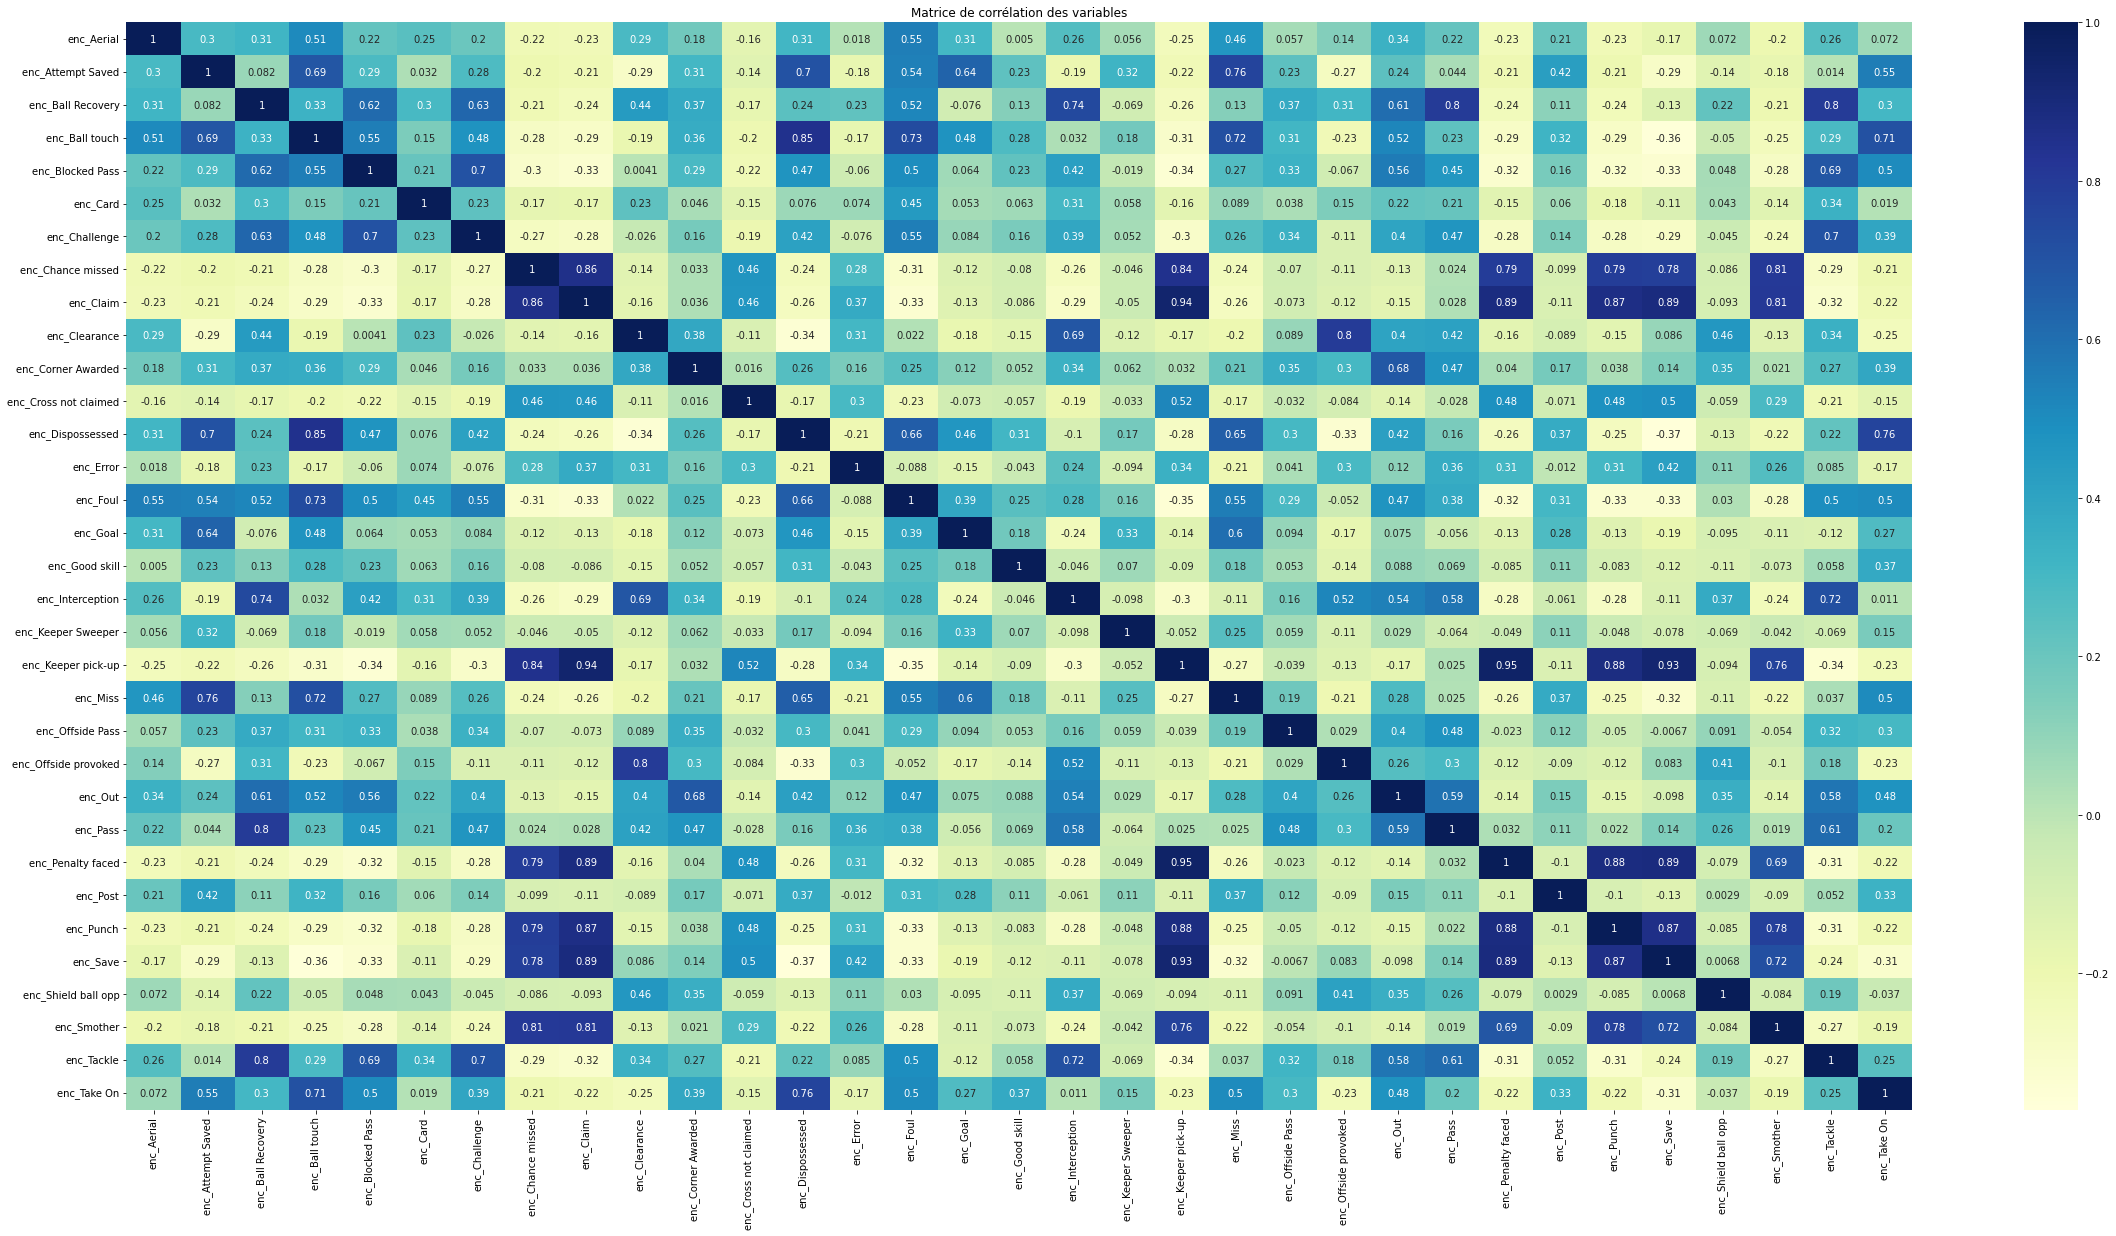

In [39]:
fig = plt.figure(figsize=(40,20))

sns.heatmap(df_corrCR.corr(), cmap="YlGnBu", annot=True);

plt.title("Matrice de corrélation des variables")
plt.show()

In [40]:
df_corrNt = pcaCR.transform(df_corrCR.values)

df_corrCRTranspose = np.array(df_corrCR).transpose()
irlambdas = 1/np.sqrt(pcaCR.explained_variance_)
mirlambdas = np.diagflat(irlambdas)
projectionsVars = (df_corrCRTranspose.dot(df_corrNt)).dot(mirlambdas)/df_corrCR.shape[0]

import plotly.graph_objects as go
from plotly.subplots import make_subplots
from itertools import combinations

fig = go.Figure()
fig = make_subplots(rows=2, cols=2)


A = [0, 1, 2]
row_list=[1,1,2]
col_list=[1,2,1]
temp = list(combinations(A, 2))
for index,facteurs in enumerate(list(temp)):
    row=row_list[index]
    col=col_list[index]
    facteur1=facteurs[0]
    facteur2=facteurs[1]

    for i, var in enumerate(df_corrCR.columns):

        # Add circles
        fig.add_shape(type="circle",
            xref="x", yref="y",
            x0=-1, y0=-1, x1=1, y1=1,
            line_color="LightSeaGreen",
            row=row, col=col
        )

        x,y = projectionsVars[i,facteur1], projectionsVars[i,facteur2]
        fig.add_trace(
            go.Scatter(
                #mode='markers',
                x=[x],
                y=[y],
                text=var.split("_")[1],
                hoverinfo='text',
                showlegend=False,

            ), row=row, col=col
        )
        fig.add_shape(
            type='line',
            x0=0, y0=0,
            x1=x,
            y1=y,
            row=row, col=col
        ),
        
        fig.update_xaxes(title_text="Facteur {} ({}%)".format(facteur1+1,round(ratios[facteur1] * 100, 1)),range=[-1, 1], row=row, col=col)

        fig.update_yaxes(title_text="Facteur {} ({}%)".format(facteur2+1,round(ratios[facteur2] * 100, 1)), range=[-1, 1], row=row, col=col)



# Set figure size

fig.update_layout(
    title="Projection des variables sur les axes des trois premières composantes",
    #xaxis_title="Facteur {} ({}%)".format(facteur1+1,round(ratios[0] * 100, 1)),
    #yaxis_title="Facteur {} ({}%)".format(facteur2+1,round(ratios[1] * 100, 1)),
    height=1000,
    width=1000,
    )



fig.show()



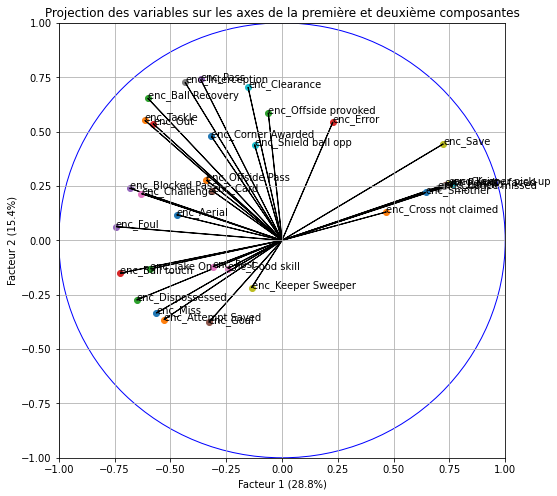

In [41]:
df_corrNt = pcaCR.transform(df_corrCR.values)

df_corrCRTranspose = np.array(df_corrCR).transpose()
irlambdas = 1/np.sqrt(pcaCR.explained_variance_)
mirlambdas = np.diagflat(irlambdas)
projectionsVars = (df_corrCRTranspose.dot(df_corrNt)).dot(mirlambdas)/df_corrCR.shape[0]

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
cercle = plt.Circle((0, 0), 1, color='b', fill=False)
ax.add_artist(cercle)
for i, var in enumerate(df_corrCR.columns):
        x,y = projectionsVars[i,0], projectionsVars[i,1]
        ax.scatter(x,y)
        ax.arrow(0, 0, x, y, shape='full', lw=1, length_includes_head=True)
        ax.text(x, y, var)
        
        
ax.set_xlabel("Facteur 1 ({}%)".format(round(ratios[0] * 100, 1)))
ax.set_ylabel("Facteur 2 ({}%)".format(round(ratios[1] * 100, 1)))
plt.title("Projection des variables sur les axes de la première et deuxième composantes")
plt.grid()
plt.show()

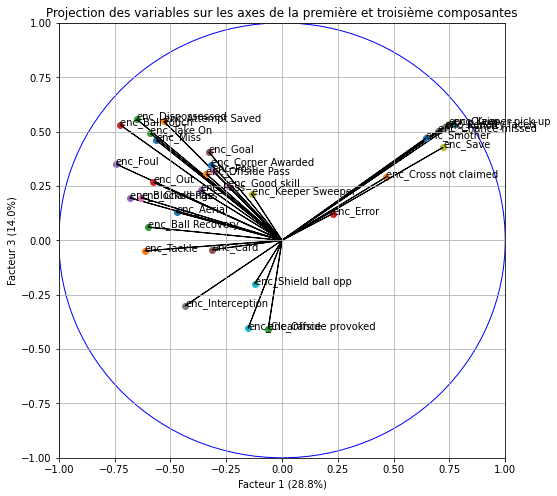

In [42]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
cercle = plt.Circle((0, 0), 1, color='b', fill=False)
ax.add_artist(cercle)
for i, var in enumerate(df_corrCR.columns):
        x,y = projectionsVars[i,0], projectionsVars[i,2]
        ax.scatter(x,y)
        ax.arrow(0, 0, x, y, shape='full', lw=1, length_includes_head=True)
        ax.text(x, y, var)
        
ax.set_xlabel("Facteur 1 ({}%)".format(round(ratios[0] * 100, 1)))
ax.set_ylabel("Facteur 3 ({}%)".format(round(ratios[2] * 100, 1))) 
plt.title("Projection des variables sur les axes de la première et troisième composantes")
plt.grid()
plt.show()

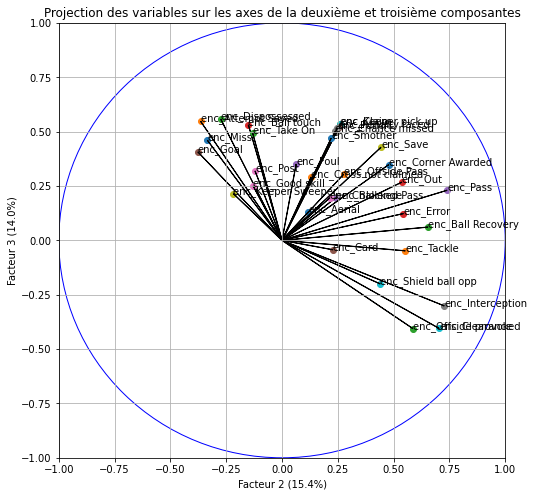

In [43]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
cercle = plt.Circle((0, 0), 1, color='b', fill=False)
ax.add_artist(cercle)
for i, var in enumerate(df_corrCR.columns):
        x,y = projectionsVars[i,1], projectionsVars[i,2]
        ax.scatter(x,y)
        ax.arrow(0, 0, x, y, shape='full', lw=1, length_includes_head=True)
        ax.text(x, y, var)

ax.set_xlabel("Facteur 2 ({}%)".format(round(ratios[1] * 100, 1)))
ax.set_ylabel("Facteur 3 ({}%)".format(round(ratios[2] * 100, 1)))    
plt.title("Projection des variables sur les axes de la deuxième et troisième composantes")
plt.grid()
plt.show()

In [44]:
df_player_event['position'].unique()

array(['Defender', 'Midfielder', 'Forward', 'Goalkeeper'], dtype=object)

In [45]:
df_corrNt = pcaCR.transform(df_corrCR.values)

df_corrCRTranspose = np.array(df_corrCR).transpose()
irlambdas = 1/np.sqrt(pcaCR.explained_variance_)
mirlambdas = np.diagflat(irlambdas)
projectionsVars = (df_corrCRTranspose.dot(df_corrNt)).dot(mirlambdas)/df_corrCR.shape[0]

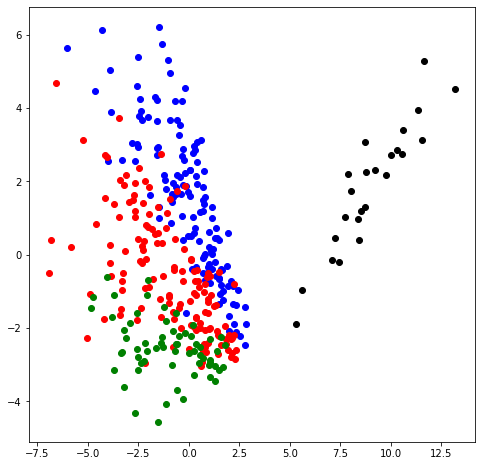

In [46]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

colors = ['Blue', 'Red', 'Green', 'Black']
position = df_player_event['position'].unique()

for pos, col in zip(position, colors):
    my_members = df_player_event['position'] == pos
    x, y = player_eventNt[my_members,0], player_eventNt[my_members,1]
    ax.scatter(x, y, c=col)

plt.show()

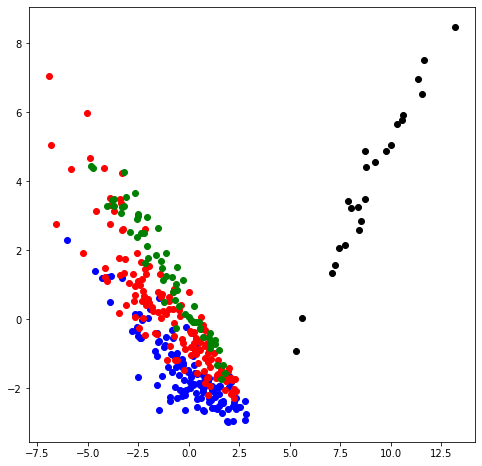

In [47]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

colors = ['Blue', 'Red', 'Green', 'Black']
position = df_player_event['position'].unique()

for pos, col in zip(position, colors):
    my_members = df_player_event['position'] == pos
    x, y = player_eventNt[my_members,0], player_eventNt[my_members,2]
    ax.scatter(x, y, c=col)

plt.show()

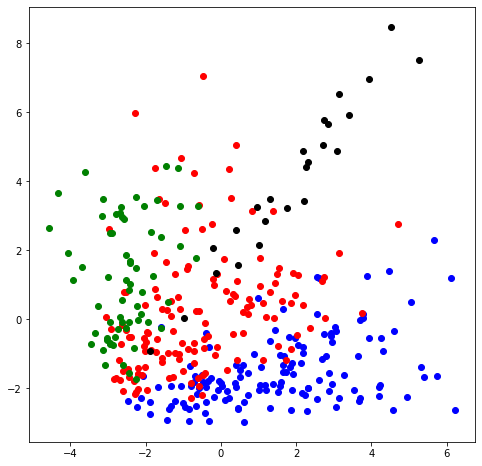

In [48]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

colors = ['Blue', 'Red', 'Green', 'Black']
position = df_player_event['position'].unique()

for pos, col in zip(position, colors):
    my_members = df_player_event['position'] == pos
    x, y = player_eventNt[my_members,1], player_eventNt[my_members,2]
    ax.scatter(x, y, c=col)

plt.show()

In [49]:
%matplotlib notebook

fig = plt.figure(figsize=(11,11))
ax = fig.add_subplot(111, projection='3d')

colors = ['Blue', 'Red', 'Green', 'Black']
position = df_player_event['position'].unique()

for pos, col in zip(position, colors):
    my_members = df_player_event['position'] == pos
    x, y, z = player_eventNt[my_members,0], player_eventNt[my_members,1], player_eventNt[my_members,2]
    ax.scatter(x, y, z, c=col)

plt.show()

<IPython.core.display.Javascript object>

In [50]:
df_player_eventNt

0         1         2         3         4         5         6   \
0   -1.575273  2.733498 -0.437750  0.741535  1.614615 -0.249337 -0.554308   
1   -1.491080  1.303780 -0.632167 -0.883921 -1.318518 -0.371774  0.331003   
2   -0.599455  1.732889 -1.187382 -1.516829 -0.042901 -0.280551  0.803696   
3   -2.228506  0.370173  0.669350 -1.654309  0.959846 -0.838968 -0.960279   
4   -0.923923  4.950880 -2.259711  1.669085 -0.057073 -0.399516  0.865401   
..        ...       ...       ...       ...       ...       ...       ...   
360 -0.778891 -2.515793  0.795709 -1.004429  0.662534 -0.396895 -0.781735   
361  1.029810 -3.335349 -0.389930  1.424759 -0.498487  1.208039 -0.280765   
362 -2.718613  1.619517  0.535657 -2.324139 -1.340373 -1.121377  0.527992   
363  8.371202  0.965458  3.255784 -0.356567  0.090524 -0.448750 -0.015383   
364  7.451639 -0.206830  2.075816 -0.421209  0.237984 -0.598926 -0.073564   

           7         8         9   ...        23        24        25  \
0   -1.041537  0.745466  0.060315  ... -0.523879  0.681192  0.612247   
1   -1.275158 -0.242172  0.862478  ... -0.704198  0.197027 -0.402779   
2    0.669482 -0.226324 -0.101584  ...  0.161091  0.591076 -0.933512   
3   -0.945080  0.436789  1.170766  ...  0.102290  0.008383  0.263576   
4   -0.208115  0.442988 -1.793649  ... -0.147013  0.070526  0.135821   
..        ...       ...       ...  ...       ...       ...       ...   
360 -0.142287  0.502735  0.207718  ...  0.386749  0.055651  0.005504   
361 -0.204322  1.296610 -1.247844  ...  0.269797 -0.486398  0.051552   
362  1.072452 -1.470066 -0.312547  ... -0.182697  0.029788 -0.160421   
363 -0.636123  0.007075  0.415122  ...  0.134134  0.261133 -0.151979   
364 -0.555866 -0.088572 -0.184789  ...  0.076510  0.464539 -0.068874   

           26        27        28        29        30        31        32  
0   -0.135179  0.592261  0.137059  0.186607  0.098610  0.107918 -0.035940  
1   -0.113660  0.139778 -0.178156  0.012244  0.167866  0.016217 -0.018372  
2   -0.231660 -0.140351 -0.057483  0.215330  0.141527 -0.104417  0.000606  
3    0.304884 -0.323460  0.038600  0.010226 -0.095702  0.087716 -0.029074  
4    0.637415 -0.218061 -0.128235 -0.155378  0.138089  0.186155 -0.116351  
..        ...       ...       ...       ...       ...       ...       ...  
360  0.409713 -0.246660  0.033677 -0.258875 -0.095624  0.135619 -0.042594  
361 -0.283804  0.242329  0.431413  0.037630 -0.106045 -0.035811  0.020123  
362 -0.049219 -0.006355 -0.771715  0.594397  0.267116  0.006637 -0.046459  
363 -0.189578  0.599958 -0.442244 -0.068796 -1.438732 -0.438272  0.437959  
364 -0.588415 -0.237730 -0.232598 -0.267534 -0.920001  0.992062  0.662977  

[365 rows x 33 columns]

In [51]:
df_player_eventNt = df_player_eventNt.reset_index()
df_player_event = df_player_event.reset_index()
df = pd.concat([df_player_eventNt, df_player_event[['name','team','position']]], axis=1)
df

index         0         1         2         3         4         5  \
0        0 -1.575273  2.733498 -0.437750  0.741535  1.614615 -0.249337   
1        1 -1.491080  1.303780 -0.632167 -0.883921 -1.318518 -0.371774   
2        2 -0.599455  1.732889 -1.187382 -1.516829 -0.042901 -0.280551   
3        3 -2.228506  0.370173  0.669350 -1.654309  0.959846 -0.838968   
4        4 -0.923923  4.950880 -2.259711  1.669085 -0.057073 -0.399516   
..     ...       ...       ...       ...       ...       ...       ...   
360    360 -0.778891 -2.515793  0.795709 -1.004429  0.662534 -0.396895   
361    361  1.029810 -3.335349 -0.389930  1.424759 -0.498487  1.208039   
362    362 -2.718613  1.619517  0.535657 -2.324139 -1.340373 -1.121377   
363    363  8.371202  0.965458  3.255784 -0.356567  0.090524 -0.448750   
364    364  7.451639 -0.206830  2.075816 -0.421209  0.237984 -0.598926   

            6         7         8  ...        26        27        28  \
0   -0.554308 -1.041537  0.745466  ... -0.135179  0.592261  0.137059   
1    0.331003 -1.275158 -0.242172  ... -0.113660  0.139778 -0.178156   
2    0.803696  0.669482 -0.226324  ... -0.231660 -0.140351 -0.057483   
3   -0.960279 -0.945080  0.436789  ...  0.304884 -0.323460  0.038600   
4    0.865401 -0.208115  0.442988  ...  0.637415 -0.218061 -0.128235   
..        ...       ...       ...  ...       ...       ...       ...   
360 -0.781735 -0.142287  0.502735  ...  0.409713 -0.246660  0.033677   
361 -0.280765 -0.204322  1.296610  ... -0.283804  0.242329  0.431413   
362  0.527992  1.072452 -1.470066  ... -0.049219 -0.006355 -0.771715   
363 -0.015383 -0.636123  0.007075  ... -0.189578  0.599958 -0.442244   
364 -0.073564 -0.555866 -0.088572  ... -0.588415 -0.237730 -0.232598   

           29        30        31        32                name         team  \
0    0.186607  0.098610  0.107918 -0.035940  François Moubandje     Toulouse   
1    0.012244  0.167866  0.016217 -0.018372       Vincent Rüfli        Dijon   
2    0.215330  0.141527 -0.104417  0.000606         Ole Selnaes   St Etienne   
3    0.010226 -0.095702  0.087716 -0.029074             Somália     Toulouse   
4   -0.155378  0.138089  0.186155 -0.116351  Christophe Kerbrat     Guingamp   
..        ...       ...       ...       ...                 ...          ...   
360 -0.258875 -0.095624  0.135619 -0.042594          Naim Sliti        Lille   
361  0.037630 -0.106045 -0.035811  0.020123      Guido Carrillo       Monaco   
362  0.594397  0.267116  0.006637 -0.046459     Benoit Pedretti        Nancy   
363 -0.068796 -1.438732 -0.438272  0.437959      Rémy Vercoutre         Caen   
364 -0.267534 -0.920001  0.992062  0.662977    Laurent Pionnier  Montpellier   

       position  
0      Defender  
1      Defender  
2    Midfielder  
3    Midfielder  
4      Defender  
..          ...  
360  Midfielder  
361     Forward  
362  Midfielder  
363  Goalkeeper  
364  Goalkeeper  

[365 rows x 37 columns]

In [52]:
fig = px.scatter_3d(df, x=0, y=1, z=2, color='position', hover_data={'name', 'team'})

fig.show()

In [53]:
#merge events and players info
df_merge = pd.merge(df_ohe, df_player_event[["player_id",'name','team','position']], on="player_id")

In [54]:
df_bar_event=df_merge.groupby("position")[column_event_id].sum()
df_bar_event

enc_Aerial  enc_Attempt Saved  enc_Ball Recovery  enc_Ball touch  \
position                                                                       
Defender        4467.0              275.0             8845.0          2223.0   
Forward         3175.0              742.0             2226.0          2504.0   
Goalkeeper        95.0                0.0              540.0            65.0   
Midfielder      4005.0              916.0             9349.0          3906.0   

            enc_Blocked Pass  enc_Card  enc_Challenge  enc_Chance missed  \
position                                                                   
Defender              1008.0     279.0         1074.0                0.0   
Forward                445.0     104.0          516.0                0.0   
Goalkeeper               1.0      16.0           10.0              221.0   
Midfielder            1598.0     289.0         2010.0                0.0   

            enc_Claim  enc_Clearance  ...  enc_Out  enc_Pass  \
position                              ...                      
Defender          0.0         7051.0  ...  10422.0   75835.0   
Forward           0.0          429.0  ...   3803.0   18830.0   
Goalkeeper      455.0          152.0  ...    895.0   11406.0   
Midfielder        0.0         1685.0  ...   8073.0   74292.0   

            enc_Penalty faced  enc_Post  enc_Punch  enc_Save  \
position                                                       
Defender                  0.0      13.0        0.0     678.0   
Forward                   0.0      30.0        0.0      37.0   
Goalkeeper               70.0       0.0      170.0    1000.0   
Midfielder                0.0      40.0        0.0     235.0   

            enc_Shield ball opp  enc_Smother  enc_Tackle  enc_Take On  
position                                                               
Defender                  120.0          0.0      3005.0       1566.0  
Forward                    10.0          0.0       655.0       1613.0  
Goalkeeper                  3.0         90.0         8.0         12.0  
Midfielder                 19.0          0.0      3226.0       3471.0  

[4 rows x 33 columns]

In [55]:
fig = go.Figure(data=[
    go.Bar(name='Defender', x=column_event_id, y=df_bar_event.iloc[0]),
    go.Bar(name='Defender', x=column_event_id, y=df_bar_event.iloc[1]),
    go.Bar(name='Defender', x=column_event_id, y=df_bar_event.iloc[2]),
    go.Bar(name='Defender', x=column_event_id, y=df_bar_event.iloc[3])
])
# Change the bar mode
fig.update_layout(barmode='stack')
fig.show()

In [56]:
fig = go.Figure(data=[
    go.Bar(name='Defender', x=np.delete(column_event_id,np.where(column_event_id=="enc_Pass")), y=df_bar_event.drop(['enc_Pass'],axis=1).iloc[0]),
    go.Bar(name='Forward', x=np.delete(column_event_id,np.where(column_event_id=="enc_Pass")), y=df_bar_event.drop(['enc_Pass'],axis=1).iloc[1]),
    go.Bar(name='Goalkeeper', x=np.delete(column_event_id,np.where(column_event_id=="enc_Pass")), y=df_bar_event.drop(['enc_Pass'],axis=1).iloc[2]),
    go.Bar(name='Midfielder', x=np.delete(column_event_id,np.where(column_event_id=="enc_Pass")), y=df_bar_event.drop(['enc_Pass'],axis=1).iloc[3])
])
# Change the bar mode
fig.update_layout(barmode='stack')
fig.show()

In [57]:
#groupby match div and player
df_player_event_time = df_merge.groupby(['player_id','match_div','position'])[column_event_id].apply(sum).reset_index()
df_player_event_time

player_id  match_div    position  enc_Aerial  enc_Attempt Saved  \
0       100954          1    Defender         8.0                1.0   
1       100954          2    Defender         5.0                0.0   
2       100954          3    Defender        10.0                0.0   
3       100954          4    Defender        11.0                0.0   
4       100954          5    Defender         6.0                0.0   
...        ...        ...         ...         ...                ...   
2184      9999          2  Goalkeeper         0.0                0.0   
2185      9999          3  Goalkeeper         0.0                0.0   
2186      9999          4  Goalkeeper         2.0                0.0   
2187      9999          5  Goalkeeper         1.0                0.0   
2188      9999          6  Goalkeeper         0.0                0.0   

      enc_Ball Recovery  enc_Ball touch  enc_Blocked Pass  enc_Card  \
0                  15.0             7.0               2.0       0.0   
1                  11.0             4.0               0.0       0.0   
2                  14.0             5.0               4.0       0.0   
3                  15.0             2.0               2.0       0.0   
4                  12.0             7.0               0.0       1.0   
...                 ...             ...               ...       ...   
2184                2.0             0.0               0.0       0.0   
2185                4.0             0.0               0.0       0.0   
2186                1.0             0.0               0.0       0.0   
2187                3.0             1.0               0.0       0.0   
2188                1.0             0.0               0.0       0.0   

      enc_Challenge  ...  enc_Out  enc_Pass  enc_Penalty faced  enc_Post  \
0               1.0  ...     32.0     146.0                0.0       0.0   
1               1.0  ...     31.0     133.0                0.0       0.0   
2               1.0  ...     18.0     116.0                0.0       0.0   
3               2.0  ...     31.0     138.0                0.0       0.0   
4               2.0  ...     21.0     121.0                0.0       0.0   
...             ...  ...      ...       ...                ...       ...   
2184            0.0  ...      4.0      45.0                0.0       0.0   
2185            0.0  ...      4.0      47.0                0.0       0.0   
2186            0.0  ...      5.0      45.0                0.0       0.0   
2187            0.0  ...      9.0      46.0                0.0       0.0   
2188            0.0  ...      3.0      49.0                0.0       0.0   

      enc_Punch  enc_Save  enc_Shield ball opp  enc_Smother  enc_Tackle  \
0           0.0       1.0                  0.0          0.0         2.0   
1           0.0       1.0                  0.0          0.0         2.0   
2           0.0       2.0                  0.0          0.0         1.0   
3           0.0       1.0                  0.0          0.0         3.0   
4           0.0       0.0                  0.0          0.0         4.0   
...         ...       ...                  ...          ...         ...   
2184        0.0       4.0                  0.0          0.0         0.0   
2185        0.0       2.0                  0.0          2.0         0.0   
2186        1.0       1.0                  0.0          0.0         0.0   
2187        0.0       3.0                  0.0          3.0         0.0   
2188        2.0       4.0                  0.0          0.0         0.0   

      enc_Take On  
0             6.0  
1            11.0  
2             1.0  
3             9.0  
4             8.0  
...           ...  
2184          0.0  
2185          0.0  
2186          0.0  
2187          0.0  
2188          0.0  

[2189 rows x 36 columns]

In [58]:
def conf_matrix(y_test,y_pred,y_class,target):
    conf_matrix=metrics.confusion_matrix(y_test, y_pred,normalize='true')
    #conf_matrix=conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    # Build the plot
    plt.figure(figsize=(4,2))
    sns.set(font_scale=0.5)
    sns.heatmap(conf_matrix, annot=True,
                cmap="Blues", linewidths=0.2)

    # Add labels to the plot

    tick_marks = np.arange(len(y_class))
    plt.xticks(tick_marks+0.5, y_class)
    plt.yticks(tick_marks+0.5, y_class)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'Confusion Matrix for {target}')
    plt.show()

In [59]:

def Roc_plot(y_classes,y_test,y_pred,target):
    y_test = label_binarize(y_test, classes=[0,1,2,3])
    y_pred=label_binarize(y_pred, classes=[0,1,2,3])

    falsePos = {}
    truePos = {}
    roc_area = {}
    fig = go.Figure()
    for i in range(len(y_classes)):
        falsePos[i], truePos[i], _ = metrics.roc_curve(y_test[:, i], y_pred[:, i])
        roc_area[i] = metrics.auc(falsePos[i], truePos[i])
    for i in range(len(y_classes)):
        fig.add_trace(go.Scatter(x=falsePos[i], y=truePos[i], name=f'ROC of class {y_classes[i]} (area = {round(roc_area[i],2)})', mode='lines'))
  
    fig.add_shape(x0=0, x1=1, y0=0, y1=1,type='line', line=dict(dash='dash'))

    fig.update_layout(
        xaxis_title='False Positive Rate',
        yaxis_title='True Positive Rate',
        title=f'ROC curves for {target}',
        width=800,
        height=400,
    )
    fig.show()

In [60]:
X=df_player_event[column_event_id]
y=df_player_event['position']

scaler=StandardScaler()
X_Sc=scaler.fit_transform(X)
le=LabelEncoder()
le.fit(y)
y_classes=le.classes_
y=le.transform(y)
X_train, X_test, y_train, y_test = train_test_split(X_Sc, y, test_size=0.2)

classifier=LogisticRegression(multi_class="multinomial",max_iter=200).fit(X_train,y_train)
y_pred=classifier.predict(X_test)
#print(metrics.classification_report(y_test, classifier.predict(X_test)))
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.92      0.91        26
           1       0.80      0.80      0.80        10
           2       1.00      1.00      1.00         7
           3       0.86      0.83      0.85        30

    accuracy                           0.88        73
   macro avg       0.89      0.89      0.89        73
weighted avg       0.88      0.88      0.88        73



In [61]:
conf_matrix(y_test, y_pred,y_classes,"Logistic Regression")
Roc_plot(y_classes,y_test,y_pred,"Logistic Regression")

<IPython.core.display.Javascript object>

In [62]:
X_PCA=df.iloc[:,1:4]
y_PCA=df['position']
le=LabelEncoder()
le.fit(y_PCA)
y_classes=le.classes_
y_PCA=le.transform(y_PCA)
X_train, X_test, y_train, y_test = train_test_split(X_PCA, y_PCA, test_size=0.2)

classifier=LogisticRegression(multi_class="multinomial",max_iter=200).fit(X_train,y_train)
y_pred=classifier.predict(X_test)
#print(metrics.classification_report(y_test, classifier.predict(X_test)))
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.82      0.85        34
           1       1.00      0.72      0.84        18
           2       1.00      1.00      1.00         4
           3       0.54      0.76      0.63        17

    accuracy                           0.79        73
   macro avg       0.85      0.83      0.83        73
weighted avg       0.84      0.79      0.80        73



In [63]:
# Confusion matrix
conf_matrix(y_test, y_pred,y_classes,"PCA+Logistic Regression")
Roc_plot(y_classes,y_test,y_pred,"PCA + Logistic Regression")

<IPython.core.display.Javascript object>